In [22]:
import json
from os import path, listdir
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import warnings
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, precision_score, recall_score
from kneed import KneeLocator
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')

# Read Dataset

In [2]:
with open("../general_rule.json", "r") as f:
    json_data = json.load(f)
    f.close()
dir = path.join('../', json_data['DataFolder']['__root__'], json_data['DataFolder']['TrainData'])
data = pd.DataFrame()
for files in listdir(dir):
    df_tmp = pd.read_csv(path.join(dir, files))
    data = pd.concat([data, df_tmp], ignore_index=True)

print('The Shape of the DataFrame is: ', data.shape)
data.head()

The Shape of the DataFrame is:  (30000, 25)


,sno,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,MARRIAGE.1,PAY_0,PAY_0.1,PAY_0.2,PAY_0.3,...,BILL_AMT1.3,BILL_AMT1.4,BILL_AMT1.5,PAY_0.6,PAY_0.7,PAY_0.8,PAY_0.9,PAY_0.10,PAY_0.11,default.payment.next.month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Splitting Dataset into Train & Test

In [3]:
df_train, df_test = train_test_split(data, test_size=0.33, random_state=10)
print('Total TRAIN records: ', df_train.shape)
print('Total TEST records: ', df_test.shape)

Total TRAIN records:  (20100, 25)
Total TEST records:  (9900, 25)


# Dataset Information

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20100 entries, 1166 to 17673
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   sno                         20100 non-null  int64
 1   LIMIT_BAL                   20100 non-null  int64
 2   SEX                         20100 non-null  int64
 3   EDUCATION                   20100 non-null  int64
 4   MARRIAGE                    20100 non-null  int64
 5   MARRIAGE.1                  20100 non-null  int64
 6   PAY_0                       20100 non-null  int64
 7   PAY_0.1                     20100 non-null  int64
 8   PAY_0.2                     20100 non-null  int64
 9   PAY_0.3                     20100 non-null  int64
 10  PAY_0.4                     20100 non-null  int64
 11  PAY_0.5                     20100 non-null  int64
 12  BILL_AMT1                   20100 non-null  int64
 13  BILL_AMT1.1                 20100 non-null  int64
 14  BIL

# Checking NULL entries

In [5]:
df_train.isna().sum()

sno                           0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
MARRIAGE.1                    0
PAY_0                         0
PAY_0.1                       0
PAY_0.2                       0
PAY_0.3                       0
PAY_0.4                       0
PAY_0.5                       0
BILL_AMT1                     0
BILL_AMT1.1                   0
BILL_AMT1.2                   0
BILL_AMT1.3                   0
BILL_AMT1.4                   0
BILL_AMT1.5                   0
PAY_0.6                       0
PAY_0.7                       0
PAY_0.8                       0
PAY_0.9                       0
PAY_0.10                      0
PAY_0.11                      0
default.payment.next.month    0
dtype: int64

In [6]:
# df_train.pairplot(data, hue='default.payment.next.month')

# Checking Correlation

<AxesSubplot:>

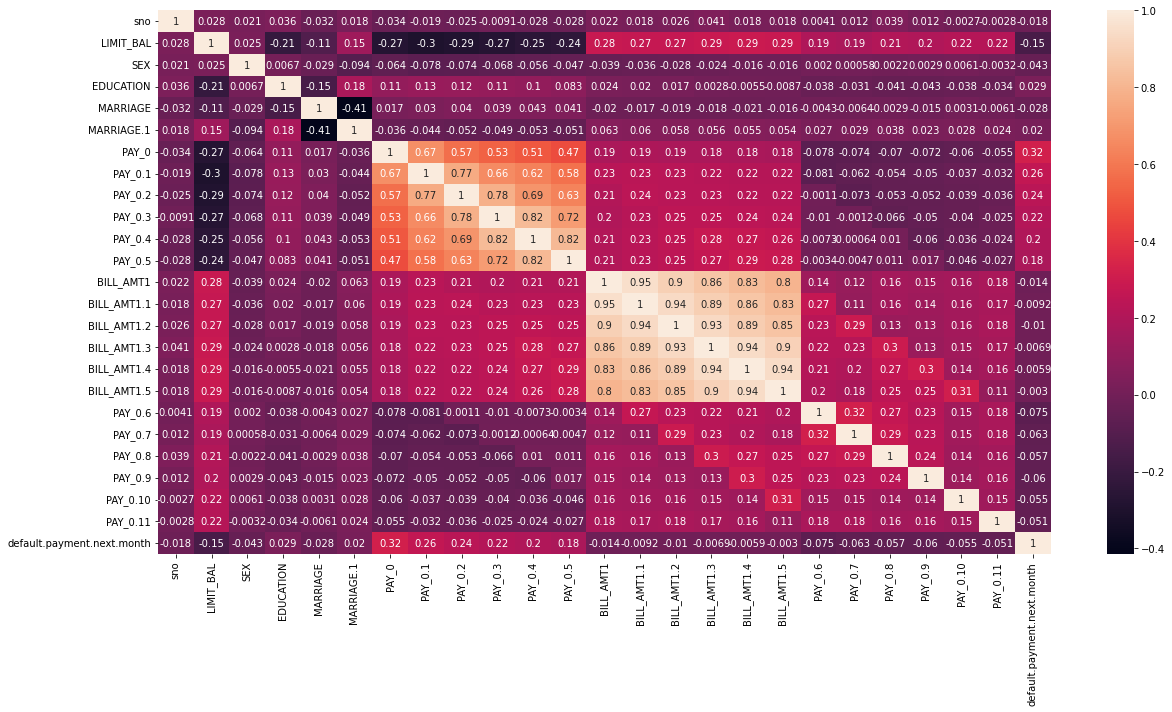

In [7]:
plt.figure(figsize=(20,10))
sns.heatmap(df_train.corr(), annot=True )

## Identifying the highly correlated columns

In [8]:
# Determining the higly correlated columns (correlation > 89%)
df_tmp = df_train.corr()
corr_col=[]

for row in range(df_tmp.shape[0]):
    for col in range(df_tmp.shape[1]):
        try:
            if row < col and abs(df_tmp.iloc[row,col]) >= 0.89:
                corr_col.append(df_tmp.columns[row])
                break
        except:
            print("Index Fail: ", row, ",", col)

print("The highly related columns are:")
corr_col  

The highly related columns are:


['BILL_AMT1', 'BILL_AMT1.1', 'BILL_AMT1.2', 'BILL_AMT1.3', 'BILL_AMT1.4']

## Removing the highly correlated columns

In [9]:
print("Original dimensions of training dataset: ", df_train.shape)
df_train.drop(corr_col, axis=1, inplace=True)
df_test.drop(corr_col, axis=1, inplace=True)
print("New dimensions of training dataset: ", df_train.shape)

Original dimensions of training dataset:  (20100, 25)
New dimensions of training dataset:  (20100, 20)


# Checking Data Imbalance

In [10]:
tmp = df_train['default.payment.next.month'].value_counts()
print('---- TRAINING DATA ----')
print(tmp)
print('Non-Fraud %: ',round((tmp[0]/len(df_train))*100,2))
print('Fraud %: ', round((tmp[1]/len(df_train))*100,2))
print('\n')

print('---- TEST DATA ----')
tmp = df_test['default.payment.next.month'].value_counts()
print(df_test['default.payment.next.month'].value_counts())
print('Non-Fraud %: ',round((tmp[0]/len(df_test))*100,2))
print('Fraud %: ', round((tmp[1]/len(df_test))*100,2))

---- TRAINING DATA ----
0    15694
1     4406
Name: default.payment.next.month, dtype: int64
Non-Fraud %:  78.08
Fraud %:  21.92


---- TEST DATA ----
0    7670
1    2230
Name: default.payment.next.month, dtype: int64
Non-Fraud %:  77.47
Fraud %:  22.53


## Over Sampling

In [11]:
# Train data
X_train = df_train.drop(labels=['default.payment.next.month'], axis=1)
y_train = df_train['default.payment.next.month']

# Test data
X_test = df_test.drop(labels=['default.payment.next.month'], axis=1)
y_test = df_test['default.payment.next.month']

In [12]:
smk = SMOTETomek(random_state = 42)
X_train, y_train = smk.fit_resample(X_train, y_train)

print("After Imbalance adjustment:")
print(X_train.shape, y_train.shape)
print(y_train.value_counts(normalize=True))

After Imbalance adjustment:
(30294, 19) (30294,)
0    0.5
1    0.5
Name: default.payment.next.month, dtype: float64


# Scaling Data

In [13]:
scaler = StandardScaler() #RobustScaler()
X_train_scale = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scale = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Model Creation

## Direct Model Approach

In [14]:
classifiers = {
    "LR": LogisticRegression(),
    "KNN": KNC(),
    "SVC": SVC(),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(verbose=0),
    "XGB": XGBClassifier(verbosity=0)
}
skf = StratifiedKFold(n_splits=5)
for key, classifier in classifiers.items():
    training_score = cross_val_score(classifier, X_train_scale, y_train, cv=skf)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 73.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 75.0 % accuracy score
Classifiers:  SVC Has a training score of 75.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 74.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 83.0 % accuracy score
Classifiers:  XGBClassifier Has a training score of 81.0 % accuracy score


In [15]:
# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
                 }
grid_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params).fit(X_train_scale, y_train)
logreg_estm = grid_log_reg.best_estimator_

# KNN
knn_params = { "n_neighbors": list(range(2,5,1)),
               "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
            }
grid_knears = RandomizedSearchCV(KNC(), knn_params).fit(X_train_scale, y_train)
knn_estm = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = RandomizedSearchCV(SVC(), svc_params).fit(X_train_scale, y_train)
svc_estm = grid_svc.best_estimator_

# Decision Tree
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = RandomizedSearchCV(DecisionTreeClassifier(), tree_params).fit(X_train_scale, y_train)
dt_estm= grid_tree.best_estimator_

# Random Forest
rforest_params = { 'max_depth': range(5, 15, 5),
                   'min_samples_leaf': range(100, 300, 100),
                   'min_samples_split': range(100, 300, 100),
                   'criterion':["entropy", "gini"],
                   'verbose':[0]
                 }
grid_rforest = RandomizedSearchCV(RandomForestClassifier(), rforest_params).fit(X_train_scale, y_train)
rforest_estm = grid_rforest.best_estimator_

# XGBoost
xgb_params = { "n_estimators": [100, 500, 1000],
               "learning_rate": [0.05, 0.10, 0.15],
               "max_depth": range(3,15,3),
               "gamma": [0.0, 0.1, 0.2],
               "verbosity": [0]
             }
grid_xgb = RandomizedSearchCV(XGBClassifier(), xgb_params).fit(X_train_scale, y_train)
xgb_estm = grid_xgb.best_estimator_

In [16]:
log_reg_score = cross_val_score(logreg_estm, X_train_scale, y_train, cv=skf)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knn_estm, X_train_scale, y_train, cv=skf)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc_estm, X_train_scale, y_train, cv=skf)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(dt_estm, X_train_scale, y_train, cv=skf)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

rforest_score = cross_val_score(rforest_estm, X_train_scale, y_train, cv=skf)
print('RandomForest Classifier Cross Validation Score', round(rforest_score.mean() * 100, 2).astype(str) + '%')

xgb_score = cross_val_score(xgb_estm, X_train_scale, y_train, cv=skf)
print('XGB Classifier Cross Validation Score', round(xgb_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  72.58%
Knears Neighbors Cross Validation Score 75.4%
Support Vector Classifier Cross Validation Score 75.42%
DecisionTree Classifier Cross Validation Score 70.32%
RandomForest Classifier Cross Validation Score 76.59%
XGB Classifier Cross Validation Score 85.15%


In [18]:
def print_recall_score(y_actual, logreg_pred, knn_pred, svc_pred, dt_pred, rforest_pred, xgb_pred, title="\n"):
    print(title)
    print("Recall for Logistic Regression:", recall_score(y_actual.values, logreg_pred))
    print("Recall for KNN:", recall_score(y_actual, knn_pred))
    print("Recall for SVC:", recall_score(y_actual, svc_pred))
    print("Recall for Decision Tree:", recall_score(y_actual, dt_pred))
    print("Recall for RandomForest:", recall_score(y_actual, rforest_pred))
    print("Recall for XGB:", recall_score(y_actual, xgb_pred))
    
def print_roc_score(y_actual, logreg_pred, knn_pred, svc_pred, dt_pred, rforest_pred, xgb_pred, title="\n"):
    print(title)
    print('ROC Score of Logistic Regression: ', roc_auc_score(y_actual, logreg_pred))
    print('ROC Score of KNears Neighbors: ', roc_auc_score(y_actual, knn_pred))
    print('ROC Score of Support Vector Classifier: ', roc_auc_score(y_actual, svc_pred))
    print('ROC Score of Decision Tree Classifier: ', roc_auc_score(y_actual, dt_pred))
    print('ROC Score of Random Forest Classifier: ', roc_auc_score(y_actual, rforest_pred))
    print('ROC Score of XGB Classifier: ', roc_auc_score(y_actual, xgb_pred))

In [20]:
logreg_pred = cross_val_predict(logreg_estm, X_train_scale, y_train, cv=skf) #, method="decision_function")
knn_pred = cross_val_predict(knn_estm, X_train_scale, y_train, cv=skf)
svc_pred = cross_val_predict(svc_estm, X_train_scale, y_train, cv=skf)#, method="decision_function")
dt_pred = cross_val_predict(dt_estm, X_train_scale, y_train, cv=skf)
rforest_pred = cross_val_predict(rforest_estm, X_train_scale, y_train, cv=skf)
xgb_pred = cross_val_predict(xgb_estm, X_train_scale, y_train, cv=skf)

In [21]:
# PRINT RECALL SCORE
print_recall_score(y_train,
                   logreg_pred,
                   knn_pred,
                   svc_pred,
                   dt_pred,
                   rforest_pred,
                   xgb_pred,
                   title="RECALL SCORE FOR TRAIN DATA")
print("\n")
# PRINT ROC SCORE
print_roc_score(y_train,
                logreg_pred,
                knn_pred,
                svc_pred,
                dt_pred,
                rforest_pred,
                xgb_pred,
                title="ROC SCORE FOR TRAIN DATA")

RECALL SCORE FOR TRAIN DATA
Recall for Logistic Regression: 0.7277348649897669
Recall for KNN: 0.7881428665742392
Recall for SVC: 0.7099095530468079
Recall for Decision Tree: 0.6409850135340331
Recall for RandomForest: 0.7295173961840629
Recall for XGB: 0.8256420413283159


ROC SCORE FOR TRAIN DATA
ROC Score of Logistic Regression:  0.7257872846108141
ROC Score of KNears Neighbors:  0.7540437050240972
ROC Score of Support Vector Classifier:  0.7542087542087541
ROC Score of Decision Tree Classifier:  0.7032085561497327
ROC Score of Random Forest Classifier:  0.7668845315904139
ROC Score of XGB Classifier:  0.8514887436456063


## Clustering Approach

### Find the optimal number of clusters

Optimal Number of Clusters:  4


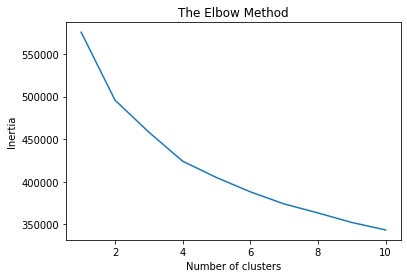

In [24]:
inertia = []
try:
    for i in range(1, 11):
        # Initializing the KMeans object
        kmeans = KMeans(
            n_clusters=i, init="k-means++", random_state=10
        )
        # Fitting the data to the KMeans Algorithm
        kmeans.fit(X_train_scale)
        inertia.append(kmeans.inertia_)

    # Creating the graph between Inertia and the number of clusters
    plt.plot(range(1, 11), inertia)
    plt.title("The Elbow Method")
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")

    # finding the value of the optimum cluster programmatically
    kn = KneeLocator(
        range(1, 11),
        inertia,
        curve="convex",
        direction="decreasing",
    )
    print('Optimal Number of Clusters: ', kn.knee)
    no_of_clusters = kn.knee

except Exception as exception_msg:
    print(exception_msg)

### Create Clusters

#### Assign cluster number to each dataset records

In [25]:
try:
    kmeans = KMeans(
        n_clusters=no_of_clusters,
        init="k-means++",
        random_state=10,
    )
    #  Divide data into clusters
    y_kmeans = kmeans.fit_predict(X_train_scale)
    # Create a new column to identify the cluster information
    X_train_scale["Cluster"] = y_kmeans
    X_train_scale["Labels"] = y_train
except Exception as exception_msg:
    print(exception_msg)

In [26]:
X_train_scale.head()

,sno,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,MARRIAGE.1,PAY_0,PAY_0.1,PAY_0.2,PAY_0.3,PAY_0.4,PAY_0.5,BILL_AMT1.5,PAY_0.6,PAY_0.7,PAY_0.8,PAY_0.9,PAY_0.10,PAY_0.11,Cluster
0,-1.609043,0.351174,-1.018996,-1.025756,1.065776,1.869375,-0.144649,-0.029264,0.017530,0.070163,0.122511,0.152998,0.980807,0.057120,0.026303,-0.038502,-0.042555,-0.060791,-0.079354,3
1,-0.134087,-0.596258,-1.018996,0.324535,-0.875926,0.509402,-1.057561,-0.873562,-0.832139,0.070163,0.122511,0.152998,-0.200818,-0.320711,0.160094,-0.246131,-0.236511,1.108532,-0.189900,3
2,-0.716093,-0.122542,0.981358,-1.025756,1.065776,-0.850570,-0.144649,-0.029264,0.017530,0.070163,1.904675,1.918010,1.756604,-0.008239,0.072733,0.469190,0.100608,0.073235,-0.282227,3
3,-0.201029,0.824890,0.981358,0.324535,-0.875926,0.396071,-0.144649,-0.029264,0.017530,0.070163,0.122511,0.152998,1.606494,0.423904,-0.022508,0.004978,0.161140,0.122535,-0.282227,3
4,-1.745162,-1.069973,-1.018996,1.674827,1.065776,-0.057253,-1.970474,-1.717861,-1.681808,-1.657908,-0.768571,-0.729508,-0.419304,-0.336106,-0.278752,-0.277232,0.662998,-0.221015,-0.282227,0


#### Dataset Split, Scaling and Model Training

In [ ]:
from inspect import currentframe, getframeinfo
from os import path

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

def get_best_params_for_dtree(train_x, train_y, log_writer):
    try:
        # Initializing with different combination of parameters
        param_grid_dtree = {
            "criterion": ["gini", "entropy"],
            "max_depth": list(range(2, 4, 1)),
            "min_samples_leaf": list(range(5, 7, 1)),
            "random_state": [0, 50, 100],
        }
        # Creating an object of the Grid Search class
        cv = StratifiedKFold(
            n_splits=10, shuffle=True, random_state=1
        )
        grid = RandomizedSearchCV(
            DecisionTreeClassifier(),
            param_grid_dtree,
            verbose=3,
            cv=cv,
            n_jobs=-1,
        )
        # Finding the best parameters
        grid.fit(train_x, train_y)

        # Creating a new model with the best parameters
        dtree = DecisionTreeClassifier(
            criterion=grid.best_params_["criterion"],
            max_depth=grid.best_params_["max_depth"],
            min_samples_leaf=grid.best_params_["min_samples_leaf"],
            random_state=grid.best_params_["random_state"],
            n_jobs=-1,
        )
        # Training the mew model
        dtree.fit(train_x, train_y)
        return dtree
    except Exception as exception_msg:
        raise exception_msg

def get_best_params_for_knn(train_x, train_y, log_writer):
    try:
        # Initializing with different combination of parameters
        param_grid_knn = {
            "n_neighbors": list(range(2, 5, 1)),
            "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
            "random_state": [0, 50, 100],
        }
        # Creating an object of the Grid Search class
        cv = StratifiedKFold(
            n_splits=10, shuffle=True, random_state=1
        )
        grid = RandomizedSearchCV(
            KNC(),
            param_grid_knn,
            verbose=3,
            cv=cv,
            n_jobs=-1,
        )
        # Finding the best parameters
        grid.fit(train_x, train_y)

        # Creating a new model with the best parameters
        knc = KNC(
            n_neighbors=grid.best_params_["n_neighbors"],
            algorithm=grid.best_params_["algorithm"],
            random_state=grid.best_params_["random_state"],
            n_jobs=-1,
        )
        # Training the mew model
        knc.fit(train_x, train_y)
        return knc
    except Exception as exception_msg:
        raise exception_msg

def get_best_params_for_logreg(train_x, train_y, log_writer):
    try:
        # Initializing with different combination of parameters
        param_grid_logreg = {
            "penalty": ["l1", "l2"],
            "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            "random_state": [0, 50, 100],
        }
        # Creating an object of the Grid Search class
        cv = StratifiedKFold(
            n_splits=10, shuffle=True, random_state=1
        )
        grid = RandomizedSearchCV(
            LogisticRegression(),
            param_grid_logreg,
            verbose=3,
            cv=cv,
            n_jobs=-1,
        )
        # Finding the best parameters
        grid.fit(train_x, train_y)

        # Creating a new model with the best parameters
        logreg = LogisticRegression(
            penalty=grid.best_params_["penalty"],
            C=grid.best_params_["C"],
            random_state=grid.best_params_["random_state"],
            n_jobs=-1,
        )
        # Training the mew model
        logreg.fit(train_x, train_y)
        return logreg
    except Exception as exception_msg:
        raise exception_msg

def get_best_params_for_rforest(train_x, train_y, log_writer):
    try:
        # Initializing with different combination of parameters
        param_grid_rf = {
            "n_estimators": [50, 100, 130],
            "max_depth": range(3, 11, 1),
            "random_state": [0, 50, 100],
            "max_features": ["auto", "sqrt"],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "bootstrap": [True, False],
        }
        # Creating an object of the Grid Search class
        cv = StratifiedKFold(
            n_splits=10, shuffle=True, random_state=1
        )
        grid = RandomizedSearchCV(
            RandomForestClassifier(),
            param_grid_rf,
            verbose=3,
            cv=cv,
            n_jobs=-1,
        )
        # Finding the best parameters
        grid.fit(train_x, train_y)

        # Creating a new model with the best parameters
        rf = RandomForestClassifier(
            n_estimators=grid.best_params_["n_estimators"],
            max_depth=grid.best_params_["max_depth"],
            random_state=grid.best_params_["random_state"],
            max_features=grid.best_params_["max_features"],
            min_samples_split=grid.best_params_[
                "min_samples_split"
            ],
            min_samples_leaf=grid.best_params_["min_samples_leaf"],
            bootstrap=grid.best_params_["bootstrap"],
            n_jobs=-1,
        )
        # Training the mew model
        rf.fit(train_x, train_y)
        return rf
    except Exception as exception_msg:
        raise exception_msg

def get_best_params_for_svc(train_x, train_y, log_writer):
    try:
        # Initializing with different combination of parameters
        param_grid_svc = {
            "C": [0.5, 0.7, 0.9, 1],
            "kernel": ["rbf", "poly", "sigmoid", "linear"],
            "random_state": [0, 50, 100],
        }
        # Creating an object of the Grid Search class
        cv = StratifiedKFold(
            n_splits=10, shuffle=True, random_state=1
        )
        grid = RandomizedSearchCV(
            SVC(),
            param_grid_svc,
            verbose=3,
            cv=cv,
            n_jobs=-1,
        )
        # finding the best parameters
        grid.fit(train_x, train_y)

        # creating a new model with the best parameters
        svc = SVC(
            C=grid.best_params_["C"],
            kernel=grid.best_params_["kernel"],
            random_state=grid.best_params_["random_state"],
            n_jobs=-1,
        )
        # training the mew model
        svc.fit(train_x, train_y)
        return svc
    except Exception as exception_msg:
        raise exception_msg

def get_best_params_for_xgboost(train_x, train_y, log_writer):
    try:
        # initializing with different combination of parameters
        param_grid_xgboost = {
            "n_estimators": [50, 100, 130],
            "max_depth": range(3, 11, 1),
            "random_state": [0, 50, 100],
        }
        # Creating an object of the Ramdomized Search class
        cv = StratifiedKFold(
            n_splits=10, shuffle=True, random_state=1
        )
        grid = RandomizedSearchCV(
            XGBClassifier(objective="binary:logistic"),
            param_grid_xgboost,
            verbose=3,
            cv=cv,
            n_jobs=-1,
        )

        # finding the best parameters
        grid.fit(train_x, train_y)

        # creating a new model with the best parameters
        xgb = XGBClassifier(
            random_state=grid.best_params_["random_state"],
            max_depth=grid.best_params_["max_depth"],
            n_estimators=grid.best_params_["n_estimators"],
            n_jobs=-1,
        )
        # training the mew model
        xgb.fit(train_x, train_y)
        return xgb
    except Exception as exception_msg:
        raise exception_msg

def get_model_score(
    model, model_name, test_x, test_y, log_writer
):
    model_pred = model.predict(test_x)
    # If there is only one label in y, accuracy is considered
    # Else, roc_auc_score is considered
    if len(test_y.unique()) == 1:
        model_score = accuracy_score(test_y, model_pred)
    else:
        # AUC Score
        model_score = roc_auc_score(test_y, model_pred)
    return model_score

def get_best_model(
   train_x, train_y, test_x, test_y, log_writer
):
    all_model_score = dict()
    classifiers = {
        "DTree": "get_best_params_for_dtree",
        "KNN": "get_best_params_for_knn",
        "LogReg": "get_best_params_for_logreg",
        "RandomForest": "get_best_params_for_rforest",
        "SVC": "get_best_params_for_svc",
        "XGBoost": "get_best_params_for_xgboost",
    }

    try:
        for key in classifiers:
            # Call the method to get the best parameters
            model = getattr(classifiers[key])(
                train_x, train_y, log_writer
            )
            # Calculate model score
            model_score = get_model_score(
                model, key, test_x, test_y, log_writer
            )
            # Store the score and model
            all_model_score[key] = [model_score, model]

        # Determining the best model
        best_model_name = max(
            all_model_score, key=all_model_score.get
        )
        return (
            best_model_name,
            all_model_score[best_model_name][0],  # model score
            all_model_score[best_model_name][1],  # model
        )

    except Exception as exception_msg:
        raise exception_msg
        


In [ ]:
list_of_clusters = X_train_scale["Cluster"].unique()
for i in list_of_clusters:
    # Filter the data of a particular cluster
    cluster_data = X_train_scale[X_train_scale["Cluster"] == i]
    cluster_x = cluster_data.drop(
        ["Labels", "Cluster"], axis=1
    )
    cluster_y = cluster_data["Labels"]
    x_train, x_test, y_train, y_test = train_test_split( cluster_x, cluster_y, test_size=1 / 3, random_state=49)

    # Scaling numerical columns
    scaler = StandardScaler() #RobustScaler()
    X_train_scale = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scale = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    
    # Getting the best model for each of the clusters
    model_finder = ModelTuner()
    (
        best_model_name,
        best_model_score,
        best_model,
    ) = model_finder.get_best_model(
        x_train, y_train, x_test, y_test, self.log_writer
    )
    


    